In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize']=12,10

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(255/256, 1, N)    ## red  255,192, 203
vals[:, 1] = np.linspace(192/256, 1, N)
vals[:, 2] = np.linspace(203/256, 1, N)  ## blue 75, 0, 130

Pinks = ListedColormap(vals)
top = cm.get_cmap(Pinks, 256)
bottom = cm.get_cmap('Purples', 256)
newcolors = np.vstack((top(np.linspace(0, 1, 256)),
                       bottom(np.linspace(0, 1, 256))))
newcmp = ListedColormap(newcolors, name='PinkPueple')

np.random.seed(17)

In [2]:
data = pd.read_csv('data_normalized.csv')
data.head(5)

,weight,height,closing,open_00_02,open_02_04,open_04_06,open_06_08,open_08_10,open_10_12,open_12_14,...,cuisine_y_Pizzeria,cuisine_y_Regional,cuisine_y_Seafood,cuisine_y_Vietnamese,parking_lot_none,parking_lot_public,parking_lot_valet parking,parking_lot_yes,age,target
0,0.258262,0.569555,-2.839010,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,-0.451192,2
1,0.258262,0.569555,0.814568,1,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,-0.451192,0
2,0.258262,0.569555,-0.403292,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,1,-0.451192,1
3,0.258262,0.569555,0.510103,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,-0.451192,2
4,0.258262,0.569555,0.510103,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,-0.451192,2


## Correlation Matrix

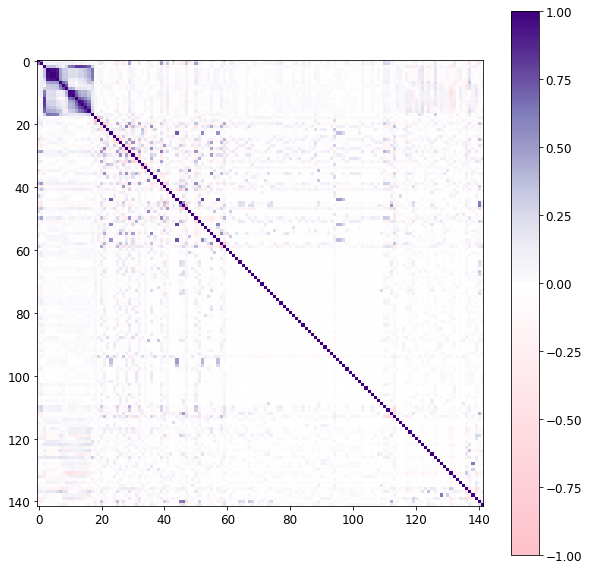

In [3]:
corr_matrix = np.corrcoef(data.T)
pd.DataFrame(corr_matrix)
plt.figure(figsize=(10,10))
plt.imshow(corr_matrix, cmap = newcmp, vmax = 1, vmin = -1)
plt.colorbar()
plt.show()

## training set, validation set, testing set

In [4]:
def split_data(data_x: np.ndarray, data_y: np.ndarray):
    
    ordering = np.arange(data_x.shape[0])
    np.random.shuffle(ordering)
    data_x = data_x[ordering]
    data_y = data_y[ordering]
    
    valid_start = int(len(data_x) * 0.7)
    test_start = int(len(data_x) * 0.9)
    
    train_set = (data_x[:valid_start], data_y[:valid_start])
    valid_set = (data_x[valid_start:test_start], data_y[valid_start:test_start])
    test_set = (data_x[test_start:], data_y[test_start:])
    
    return train_set, valid_set, test_set

In [5]:
y = np.array(data['target'])
x = np.array(data.drop(['target'], axis=1))

train_set, valid_set, test_set = split_data(x,y)

print(train_set[0].shape)
print(valid_set[0].shape)
print(test_set[0].shape)

(2055, 141)
(587, 141)
(294, 141)


In [6]:
x_train = train_set[0]
y_train = train_set[1]

x_val = valid_set[0]
y_val = valid_set[1]

x_test = test_set[0]
y_test = test_set[1]

## Simple Linear Regression - worth try :)

In [7]:
reg = Lin_Reg()
reg.fit(x_train, y_train)
coefficients = reg.coef_
reg.predict(x_val)

print('Simple Linear Regression')
#print('\nCoefficients: {:}'.format(coefficients))

output = np.round(reg.predict(x_train) ).astype(int)
target = y_train
accuracy = sum(output == target)/ len(target)
print("\n\nAccuracy on train set: {:.2f} %".format(accuracy*100))

output = np.round(reg.predict(x_val) ).astype(int)
target = y_val
accuracy = sum(output == target)/ len(target)
print("\n\nAccuracy on validation set: {:.2f} %".format(accuracy*100))

print('\nAverage Cross Validation in training set:\t{:}'.format(np.average(cross_val_score(reg,x_train, y_train, scoring ='r2',cv = 5))))
print('Average Cross Validation in test set:\t{:}'.format(np.average(cross_val_score(reg,x_test, y_test, scoring ='r2',cv = 5))))

Simple Linear Regression


Accuracy on train set: 67.40 %


Accuracy on validation set: 65.59 %

Average Cross Validation in training set:	0.27307948911375146
Average Cross Validation in test set:	-5.293267341529667e+22


# Ridge Regression

In [8]:
# Run for different values of lambda 
lambda_min = -5
lambda_max = 10
eta = 10

num_lambdas = eta * (lambda_max- lambda_min)
num_predictors = x.shape[1]
lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

train_accuracy = np.zeros(num_lambdas)
val_accuracy = np.zeros(num_lambdas)
coeff_a = np.zeros((num_lambdas, num_predictors))

In [9]:
for ind, i in enumerate(lambdas):    
    # Fit ridge regression on train set
    reg = Ridge_Reg(alpha = 10**i)
    reg.fit(x_train, y_train)
       
    coeff_a[ind,:] = reg.coef_
    
    # Evaluate train & test performance
    output = np.round(reg.predict(x_train)).astype(int)
    target = y_train
    train_accuracy[ind] = sum(output == target)/ len(target)
    
    output = np.round(reg.predict(x_val)).astype(int)
    target = y_val
    val_accuracy[ind] = sum(output == target)/ len(target)

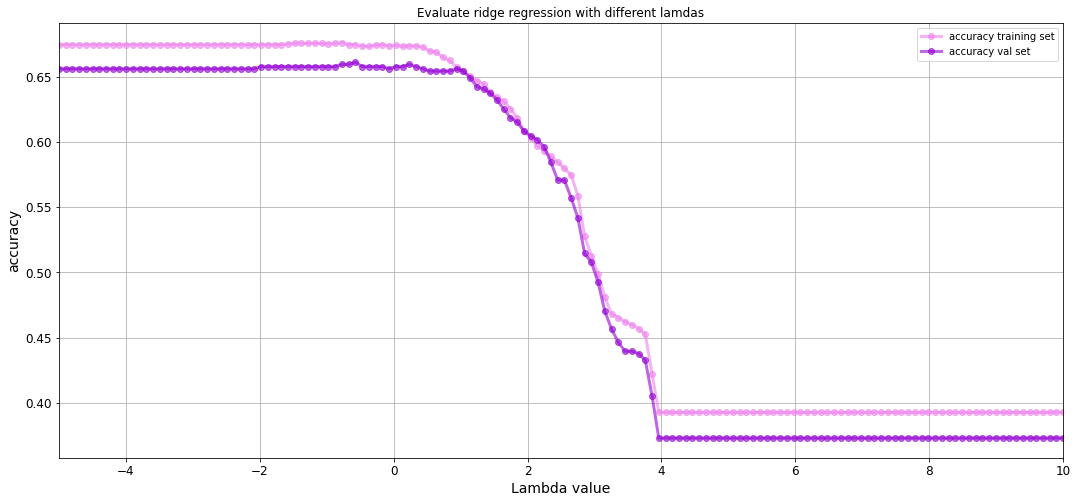

In [10]:
# Plotting
plt.figure(figsize=(18, 8))

plt.plot(lambdas, train_accuracy, 'bo-', label=r'accuracy training set', color="violet", alpha=0.6, linewidth=3)
plt.plot(lambdas, val_accuracy, 'bo-', label=r'accuracy val set', color="darkviolet", alpha=0.6, linewidth=3)

plt.xlabel('Lambda value'); plt.ylabel(r'accuracy')
plt.xlim(lambda_min, lambda_max)
plt.title(r'Evaluate ridge regression with different lamdas')
plt.legend(loc='best')
plt.grid()

# Logistic regression

In [11]:
n=30

C_arr = np.linspace(-10, 5, n)
train_accuracy = np.zeros(n)
val_accuracy = np.zeros(n)

for ind, C in enumerate(C_arr):    
    
    logreg = LogisticRegression(solver='newton-cg', C=10**C)
    logreg.fit(x_train, y_train)

    
    # Evaluate train & test performance
    output = logreg.predict(x_train)
    target = y_train
    train_accuracy[ind] =sum(output == target)/ len(target)

    output = logreg.predict(x_val)
    target = y_val
    val_accuracy[ind] =sum(output == target)/ len(target)

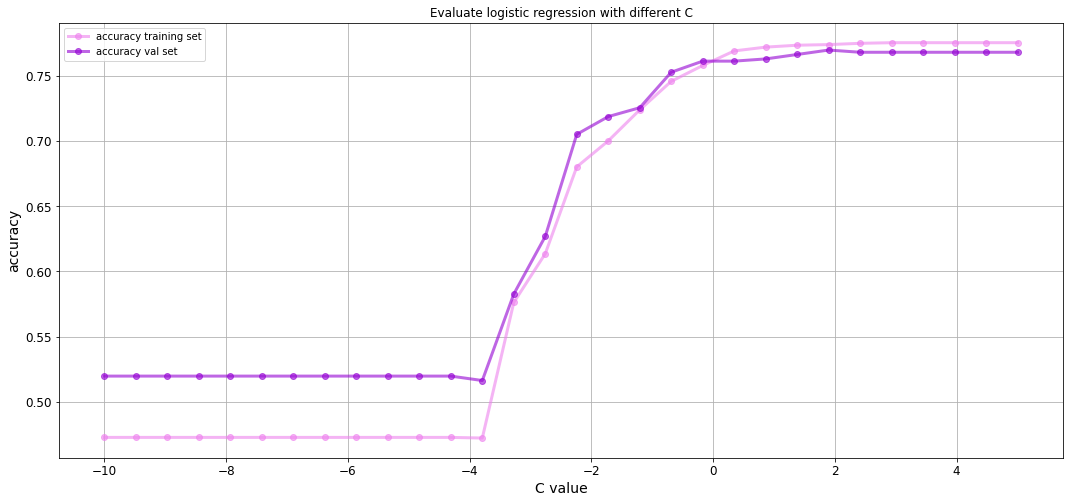

In [12]:
# Plotting
plt.figure(figsize=(18, 8))

plt.plot(C_arr, train_accuracy, 'bo-', label=r'accuracy training set', color="violet", alpha=0.6, linewidth=3)
plt.plot(C_arr, val_accuracy, 'bo-', label=r'accuracy val set', color="darkviolet", alpha=0.6, linewidth=3)

plt.xlabel('C value'); plt.ylabel(r'accuracy')
plt.title(r'Evaluate logistic regression with different C')
plt.legend(loc='best')
plt.grid()

In [13]:
index = np.argmax(val_accuracy)
C_best= C_arr[index]

logreg = LogisticRegression(solver = 'newton-cg',C=10**C_best)
logreg.fit(x_train, y_train)
coefficients = logreg.coef_

print('Logistic Regression')

output = logreg.predict(x_train)
target = y_train
accuracy = sum(output == target)/ len(target)
print("\nAccuracy on train set: {:.2f} %".format(accuracy*100))

output = logreg.predict(x_val)
target = y_val
accuracy = sum(output == target)/ len(target)
print("\nAccuracy on validation set: {:.2f} %".format(accuracy*100))


output = logreg.predict(x_test)
target = y_test
accuracy = sum(output == target)/ len(target)
print("\nAccuracy on validation set: {:.2f} %".format(accuracy*100))

Logistic Regression

Accuracy on train set: 77.42 %

Accuracy on validation set: 77.00 %

Accuracy on validation set: 71.43 %


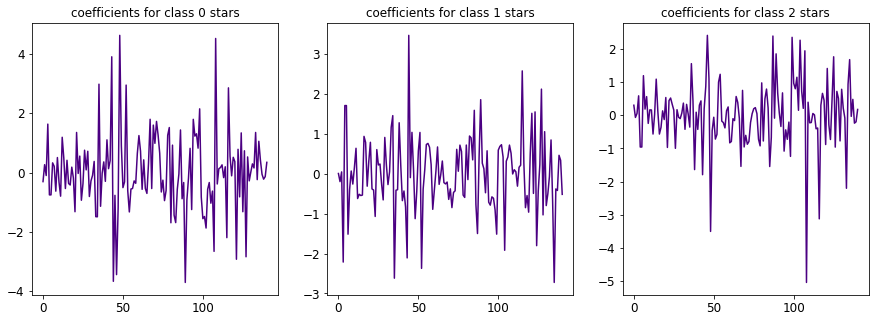

In [14]:
fig, axs= plt.subplots(1,3, figsize=(15,5))
axs[0].plot(coefficients[0],c='indigo')
axs[1].plot(coefficients[1],c='indigo')
axs[2].plot(coefficients[2],c='indigo')

axs[0].set_title("coefficients for class 0 stars")
axs[1].set_title("coefficients for class 1 stars")
axs[2].set_title("coefficients for class 2 stars")

plt.show()


# Check, what features have highest and lowest coefficients in logistic regression

In [15]:
features = list(data.columns)[:-1]

def get_most_correlated(coeffs, features, treshold):
    coeffs, features = zip(*sorted(zip( coeffs, features)))  

    for coef, feat in zip(coeffs, features):
        if abs(coef) > treshold:
            print("coef = {:.4f} \tfor\t {:}".format(coef, feat))
            
            
def get_least_correlated(coeffs, features, treshold):
    coeffs, features = zip(*sorted(zip( coeffs, features)))  ## sorting elements in (val, freq) indexing on 

    for coef, feat in zip(coeffs, features):
        if abs(coef) < treshold:
            print("coef = {:.4f} \tfor\t {:}".format(coef, feat))

## most important

In [16]:
print("Most correlated for 0 star")
get_most_correlated(coefficients[0], features, 2)

Most correlated for 0 star
coef = -3.7060 	for	 cuisine_x_Japanese
coef = -3.6680 	for	 religion_Mormon
coef = -3.4425 	for	 activity_professional
coef = -2.9240 	for	 cuisine_y_Cafe-Coffee_Shop
coef = -2.8409 	for	 cuisine_y_Game
coef = -2.6582 	for	 cuisine_x_Tex-Mex
coef = -2.1957 	for	 cuisine_y_Armenian
coef = 2.1481 	for	 cuisine_x_Pizzeria
coef = 2.8556 	for	 cuisine_y_Bakery
coef = 2.9491 	for	 color_orange
coef = 2.9794 	for	 marital_status_widow
coef = 3.9031 	for	 religion_Jewish
coef = 4.5205 	for	 cuisine_x_Turkish
coef = 4.6257 	for	 activity_unemployed


In [17]:
print("Most correlated for 1 star")
get_most_correlated(coefficients[1], features, 2)

Most correlated for 1 star
coef = -2.7262 	for	 cuisine_y_Vietnamese
coef = -2.6195 	for	 marital_status_widow
coef = -2.3730 	for	 color_orange
coef = -2.2151 	for	 open_00_02
coef = -2.1108 	for	 religion_Jewish
coef = 2.1249 	for	 cuisine_y_Game
coef = 2.5820 	for	 cuisine_y_Armenian
coef = 3.4738 	for	 religion_Mormon


In [18]:
print("Most correlated for 2 star")
get_most_correlated(coefficients[2], features, 2)

Most correlated for 2 star
coef = -5.0363 	for	 cuisine_x_Turkish
coef = -3.5001 	for	 activity_unemployed
coef = -3.1217 	for	 cuisine_y_Bakery
coef = -2.2009 	for	 cuisine_y_Regional
coef = 2.2566 	for	 cuisine_x_Soup
coef = 2.3437 	for	 cuisine_x_Polish
coef = 2.3826 	for	 cuisine_x_Indian-Pakistani
coef = 2.4029 	for	 activity_professional


### less important

In [19]:
print("Least correlated for 0 star")
get_least_correlated(coefficients[0], features, 0.2)

Least correlated for 0 star
coef = -0.1892 	for	 cuisine_x_Korean
coef = -0.1831 	for	 smoking_true
coef = -0.1716 	for	 payment_cash
coef = -0.1371 	for	 parking_lot_yes
coef = -0.1106 	for	 cuisine_y_Bar_Pub_Brewery
coef = -0.1011 	for	 closing
coef = -0.0926 	for	 transport_on foot
coef = -0.0579 	for	 parking_lot_public
coef = -0.0472 	for	 cuisine_x_Hawaiian
coef = -0.0309 	for	 drinker_social drinker
coef = -0.0268 	for	 interest_none
coef = 0.0185 	for	 cuisine_y_Japanese
coef = 0.0895 	for	 company_family
coef = 0.1281 	for	 payment_MasterCard-Eurocard
coef = 0.1309 	for	 religion_Catholic
coef = 0.1543 	for	 cuisine_y_Pizzeria
coef = 0.1686 	for	 payment_VISA
coef = 0.1818 	for	 smoking_false
coef = 0.1944 	for	 cuisine_y_American


In [20]:
print("Least correlated for 0 star")
get_least_correlated(coefficients[2], features, 0.2)

Least correlated for 0 star
coef = -0.1786 	for	 color_white
coef = -0.1630 	for	 cuisine_x_Australian
coef = -0.1315 	for	 smoking_true
coef = -0.1066 	for	 cuisine_x_Asian
coef = -0.1044 	for	 company_solitary
coef = -0.0950 	for	 cuisine_x_Bar
coef = -0.0905 	for	 cuisine_x_Italian
coef = -0.0856 	for	 cuisine_y_Pizzeria
coef = -0.0681 	for	 height
coef = -0.0626 	for	 company_friends
coef = -0.0624 	for	 color_blue
coef = -0.0362 	for	 parking_lot_none
coef = 0.0079 	for	 payment_cash
coef = 0.0236 	for	 open_19_20
coef = 0.0324 	for	 marital_status_single
coef = 0.0422 	for	 cuisine_x_Continental-European
coef = 0.0466 	for	 cuisine_x_Dessert-Ice_Cream
coef = 0.0508 	for	 payment_bank_debit_cards
coef = 0.0537 	for	 closing
coef = 0.0605 	for	 transport_car
coef = 0.0626 	for	 cuisine_x_Korean
coef = 0.0887 	for	 interest_technology
coef = 0.1205 	for	 open_21_22
coef = 0.1293 	for	 smoking_false
coef = 0.1334 	for	 budget_low
coef = 0.1465 	for	 cuisine_x_Seafood
coef = 0.1530 	f

In [21]:
print("Least correlated for 0 star")
get_least_correlated(coefficients[2], features, 0.2)

Least correlated for 0 star
coef = -0.1786 	for	 color_white
coef = -0.1630 	for	 cuisine_x_Australian
coef = -0.1315 	for	 smoking_true
coef = -0.1066 	for	 cuisine_x_Asian
coef = -0.1044 	for	 company_solitary
coef = -0.0950 	for	 cuisine_x_Bar
coef = -0.0905 	for	 cuisine_x_Italian
coef = -0.0856 	for	 cuisine_y_Pizzeria
coef = -0.0681 	for	 height
coef = -0.0626 	for	 company_friends
coef = -0.0624 	for	 color_blue
coef = -0.0362 	for	 parking_lot_none
coef = 0.0079 	for	 payment_cash
coef = 0.0236 	for	 open_19_20
coef = 0.0324 	for	 marital_status_single
coef = 0.0422 	for	 cuisine_x_Continental-European
coef = 0.0466 	for	 cuisine_x_Dessert-Ice_Cream
coef = 0.0508 	for	 payment_bank_debit_cards
coef = 0.0537 	for	 closing
coef = 0.0605 	for	 transport_car
coef = 0.0626 	for	 cuisine_x_Korean
coef = 0.0887 	for	 interest_technology
coef = 0.1205 	for	 open_21_22
coef = 0.1293 	for	 smoking_false
coef = 0.1334 	for	 budget_low
coef = 0.1465 	for	 cuisine_x_Seafood
coef = 0.1530 	f

## Comment:

Linear regression and regularized linear regression are not suitable for this particular task.
From analisys of coefficients in logistic regression the following seems to be not important:
* cuisine_x_Bar
* cuisine_x_Italian
* cuisine_y_Pizzeria

But, stutus "widow" is highly correlated with "0" and "1" star